Por: Felipe Moreira

# Analizado los crímenes en la Ciudad de Nueva York

## Parte 1

### 1. Preliminares

* El problema se trata sobre analizar los crímenes de la ciudad de NY mediante el análisis de los datos entregados por el NYPD sobre las detenciones en la vía pública
* El objetivo es desarrollar un modelo de ML que permita predecir si un procedimiento conducirá a una arresto de la persona, tambíen se pretende predecir si el procedimiento concluirá en una acción violenta
* La base entregada contiene información sobre las interrogaciones y detenciones realizada por la policia, se usarán los datos del 2009 para entrenar el modelo y los del 2010 para probar
* El vector objetivo para identificar si fue detenido o no es "arstmade", los vectores objetivos para identificar si hubo violencia son "PHYSICAL FORCE USED BY OFFICER" los cuales deberan ser recodificados en un unico vector para poder entrenar el modelo
* El problema se trata de un problema de clasificación para identifiacar si el sujeto fue detenido o no o si hubo violencia o no

**La metodología a seguir será la siguiente:**

1. Analisis exploratorio de datos: Se realizará un análisis exploratorio de los datos para comprender la distribución de las variables, identificar posibles valores atípicos o datos faltantes, y estudiar la relación entre las características y el vector objetivo.
2. Preprocesar la info: Lidiar con datos faltantes, normalización y escalado y codificación de variables categóricas 
3. Dividir el conjunto de datos: los datos para entrenar el modelo serán los del 2009 y los para probar serán los del 2010
4. seleecionar los algoritmos de clasificación a utilizar y sus grillas con valores de hiperparámetros a probar: 
    - Regresión logística: Hiperparámetros: {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
    - Árbol de decisión: Hiperparámetros: {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}
    - Random Forest: Hiperparámetros: {'n_estimators': [100, 200, 500], 'max_depth': [None, 5, 10]}
    - Gradient Boosting: Hiperparámetros: {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.1, 1]}
    - Support Vector Machines (SVM): Hiperparámetros: {'C': [1, 10, 100], 'kernel': ['linear', 'rbf']}
5. Entrenar y ajustar el modelo
6. Evaluar rendimientos de los modelos (métricas): Se utilizaraán métricas como la precisión, el recall, el F1-score y el área bajo la curva ROC (AUC-ROC). Además, se puede considerar la matriz de confusión para entender el rendimiento del modelo en términos de falsos positivos y falsos negativos.
7. Realizar predicciones

Librerias a importar:
* Pandas: para la manipulación y análisis de datos.
* NumPy: para realizar operaciones numéricas y manipulación de matrices.
* Scikit-learn: para implementar modelos de aprendizaje automático y realizar evaluación de métricas.
* Matplotlib y Seaborn: para visualización de datos.

### 2. Aspectos Computacionales

In [56]:
#librerias y modulos a implementar:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE
import preproc_nyc_sqf

import pickle

import warnings
warnings.filterwarnings('ignore')
#plt.rcParams["figure.figsize"] = (10, 6) # Tamaño gráficos
#plt.rcParams["figure.dpi"] = 200 # resolución gráficos
%matplotlib inline

In [57]:
#lectura del archivo
df = pd.read_csv('2009_1perc.csv').drop(columns='Unnamed: 0')
df_test = pd.read_csv('2010_1perc.csv').drop(columns='Unnamed: 0')
print(df.shape)
print(df_test.shape)
df.describe()

(5812, 111)
(6013, 111)


,year,pct,ser_num,datestop,timestop,perobs,perstop,compyear,comppct,repcmd,revcmd,dob,age,ht_feet,ht_inch,weight,addrpct,linecm,detailcm
count,5812.0,5812.000000,5812.000000,5.812000e+03,5812.000000,5812.000000,5812.000000,5812.0,5812.0,5812.000000,5812.000000,5.812000e+03,5812.000000,5812.000000,5812.000000,5812.000000,5812.000000,5812.0,5812.000000
mean,2009.0,69.051617,5769.119924,6.255350e+06,1426.219202,2.665893,5.501893,0.0,0.0,252.115795,249.074845,6.941142e+06,28.874054,5.188231,6.414315,169.942533,69.051617,1.0,37.488644
std,0.0,32.846903,5524.955522,3.447243e+06,736.239726,4.816704,5.922592,0.0,0.0,305.058678,306.222306,3.552806e+06,26.067172,0.402213,3.446479,37.653637,32.846903,0.0,25.059538
min,2009.0,1.000000,1.000000,1.012009e+06,0.000000,0.000000,1.000000,0.0,0.0,1.000000,1.000000,1.011900e+06,1.000000,3.000000,0.000000,1.000000,1.000000,1.0,6.000000
25%,2009.0,42.000000,1902.750000,3.172009e+06,1030.000000,1.000000,3.000000,0.0,0.0,70.000000,67.000000,4.061986e+06,19.000000,5.000000,4.000000,150.000000,42.000000,1.0,20.000000
50%,2009.0,73.000000,4347.000000,6.142009e+06,1605.000000,1.000000,5.000000,0.0,0.0,105.000000,103.000000,7.121980e+06,25.000000,5.000000,7.000000,170.000000,73.000000,1.0,28.000000
75%,2009.0,102.000000,7616.750000,9.192009e+06,2035.000000,3.000000,5.000000,0.0,0.0,178.000000,178.750000,1.012198e+07,34.000000,5.000000,9.000000,180.000000,102.000000,1.0,46.000000
max,2009.0,123.000000,31694.000000,1.231201e+07,2830.000000,200.000000,200.000000,0.0,0.0,879.000000,879.000000,1.231199e+07,999.000000,7.000000,11.000000,999.000000,123.000000,1.0,113.000000


In [58]:
#definición de funciones

def plot_classification_report(y_true, y_hat):
    """
    plot_classification_report: Genera una visualización de los puntajes reportados con la función `sklearn.metrics.classification_report`.

    Parámetros de ingreso:
        - y_true: Un vector objetivo de validación.
        - y_hat: Un vector objetivo estimado en función a la matriz de atributos de validación y un modelo entrenado.

    Retorno:
        - Un gráfico generado con matplotlib.pyplot

    """
    # process string and store in a list
    report = classification_report(y_true, y_hat).split()
    # keep values
    report = [i for i in report if i not in ['precision', 'recall', 'f1-score', 'support']]
    # transfer to a DataFrame
    report = pd.DataFrame(np.array(report).reshape(len(report) // 5, 5))
    # asign columns labels
    report.columns = ['idx', 'prec', 'rec', 'f1', 'n']
    # preserve class labels
    class_labels = report.iloc[:np.unique(y_true).shape[0]].pop('idx').apply(int)
    # separate values
    class_report = report.iloc[:np.unique(y_true).shape[0], 1:4]
    # convert from str to float
    class_report = class_report.applymap(float)
    # convert to float average report
    average_report = report.iloc[-1, 1: 4].apply(float)

    colors = ['dodgerblue', 'tomato', 'purple', 'orange']

    for i in class_labels:
        plt.plot(class_report['prec'][i], [1], marker='x', color=colors[i])
        plt.plot(class_report['rec'][i], [2], marker='x', color=colors[i])
        plt.plot(class_report['f1'][i], [3], marker='x',color=colors[i], label=f'Class: {i}')

    plt.scatter(average_report, [1, 2, 3], marker='o', color='forestgreen', label='Avg')
    plt.yticks([1.0, 2.0, 3.0], ['Precision', 'Recall', 'f1-Score'])

### 3. Análisis exploratorio

3.1 estudio del vector objetivo

<AxesSubplot:>

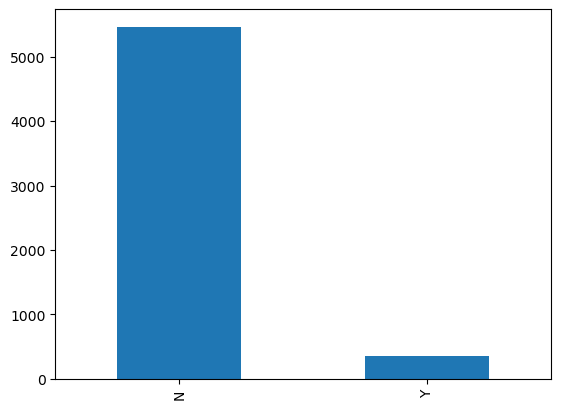

In [59]:
df['arstmade'].value_counts().plot(kind='bar')

In [60]:
df['arstmade'].describe()

count     5812
unique       2
top          N
freq      5464
Name: arstmade, dtype: object

El vector objetivo esta completamente desbalanceado por lo que se revisará de que manera abordarlo

3.2 Estudio de datos nulos

In [61]:
df.isnull().sum().sort_values(ascending=False)


year        0
sb_outln    0
dob         0
race        0
sex         0
           ..
pf_wall     0
pf_hands    0
othrweap    0
machgun     0
detailcm    0
Length: 111, dtype: int64

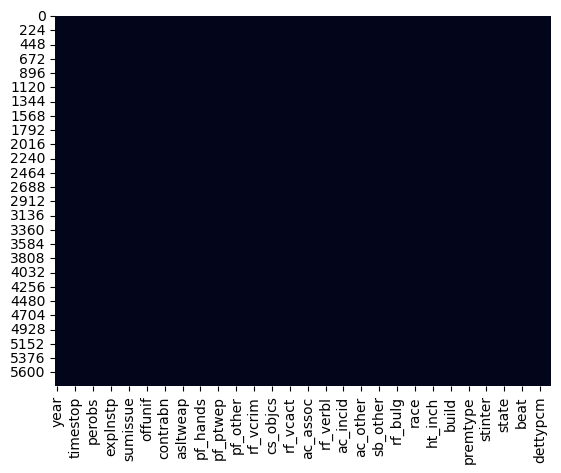

In [62]:
sns.heatmap(df.isnull(), cbar=False)
plt.show()

En el data frame no existen datos nulos

## Parte 2

### 4. Feature Engineering

4.1 recodificación del vector objetivo

<AxesSubplot:>

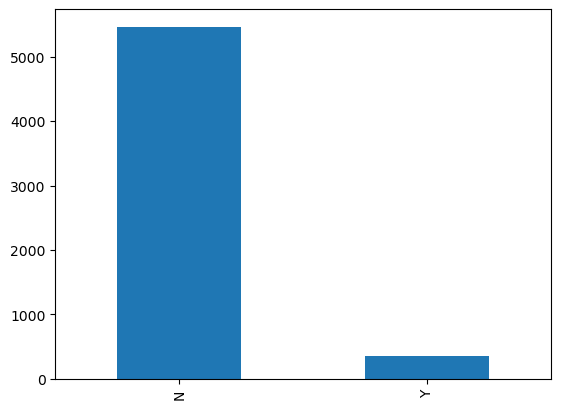

In [63]:
df['arstmade'].value_counts().plot(kind='bar')

(5812, 103)
(6013, 103)


<AxesSubplot:>

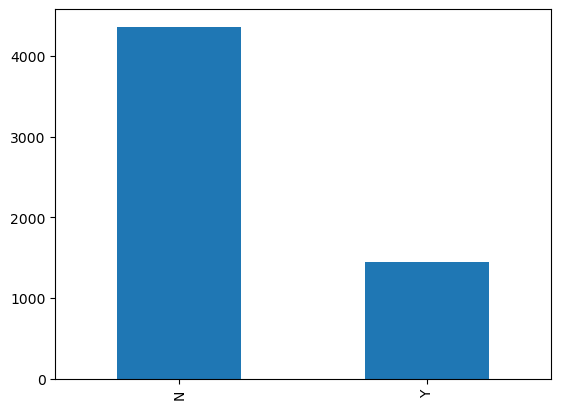

In [64]:
# recodificación del vector objetivo para violencia en arresto
def rec_violence(df):
    df['violence'] = np.where((df['pf_hands'] == 'Y') |
                            (df['pf_wall'] == 'Y') |
                            (df['pf_grnd'] == 'Y') |
                            (df['pf_drwep'] == 'Y') |
                            (df['pf_ptwep'] == 'Y') |
                            (df['pf_baton'] == 'Y') |
                            (df['pf_hcuff'] == 'Y') |
                            (df['pf_pepsp'] == 'Y') |
                            (df['pf_other'] == 'Y'), 'Y', 'N')
    #eliminación de columnas sobrantes
    df = df.drop(columns=['pf_hands', 'pf_wall', 'pf_grnd', 'pf_drwep', 'pf_ptwep', 'pf_baton',
                      'pf_hcuff', 'pf_pepsp', 'pf_other'])
    return df
    
df = rec_violence(df)
df_test = rec_violence(df_test)

print(df.shape)
print(df_test.shape)

#gráfico
df['violence'].value_counts().plot(kind='bar')

El nuevo vector creado se encuentra desbalanceado por lo que se revisará como compensarlo mediante un oversampling 

4.2 Análisis exploratorio de variables

Para terminos prácticos se hara una limpieza del df:
* Eliminación del año
* Se dejaran solo los datos de si la persona fue 'frisked' y no el motivo, lo mismo para si fue parado ('stop')
* para las columnas de location solo se dejará la columna 'city'
* Se dejará solamente una columna en caso de que el sospechoso lleva arma (si no)
* eliminación de la altura del sujeto (inches), de deja feets
* se eliminaran las columnas 'crimsusp', 'arstoffn' y 'sumoffen'
* Eliminación de dob date of birth ya que está la edad
* eliminación de clumnas que tienen un solo valor
* Eliminar columna pct

In [65]:
def limpiar_dataframe(df):
    #solo se dejara la columna si la persona fue frisked
    df.drop(columns=['rf_vcrim', 'rf_othsw', 'rf_attir', 'rf_vcact','rf_rfcmp',
                    'rf_verbl', 'rf_knowl', 'rf_furt', 'rf_bulg'], inplace=True)

    #eliminación columnas de location, solo se dejará city y sector
    df = df.drop(columns=['rescode', 'premtype', 'premname', 'addrnum', 'stname',
                        'stinter', 'crossst', 'aptnum', 'state', 'zip', 'addrpct',
                        'beat', 'sector', 'post', 'xcoord', 'ycoord'])


    #unificación en columna si el sospechoso lleva arma o no
    df['weapon'] = np.where((df['pistol'] == 'Y') |
                        (df['riflshot'] == 'Y') |
                        (df['asltweap'] == 'Y') |
                        (df['knifcuti'] == 'Y') |
                        (df['machgun'] == 'Y') |
                        (df['othrweap'] == 'Y'), 'Y', 'N')
    df.drop(columns=['pistol', 'riflshot', 'asltweap', 'knifcuti', 'machgun', 'othrweap'], inplace=True)

    #eliminación de columnas
    df.drop(columns=['crimsusp', 'arstoffn', 'sumoffen'], inplace=True)

    #eliminación de columnas con valores únicos
    df.drop(columns=['compyear', 'comppct', 'adtlrept', 'othfeatr', 'addrtyp', 'dettypcm', 'linecm'], inplace=True)

    #elimiación pct
    df.drop(columns='pct', inplace=True)

    ### Reemplazo de clases faltantes
    ### {N: No, Y: Yes, U: Unknown}
    df['officrid'] = np.where(df['officrid'] == ' ', 'N', 'Y')
    df['offshld'] = np.where(df['offshld'] == ' ', 'N', 'Y')
    #df['sector'] = np.where(df['sector'] == ' ', 'U', df['sector'])
    df['trhsloc'] = np.where(df['trhsloc'] == ' ', 'U', df['trhsloc'])
    #df['beat'] = np.where(df['beat'] == ' ', 'U', df['beat'])
    df['offverb'] = np.where(df['offverb'] == ' ', 'N', 'Y')

    #transofmración a metro y eliminacion de columnas
    meters = df['ht_feet'].astype(str) + '.' + df['ht_inch'].astype(str)
    df['meters'] = meters.apply(lambda x: float(x) * 0.3048) # Conversión de distanca a sistema metrico (non retarded)
    df.drop(columns=['ht_feet', 'ht_inch'], inplace=True)

    df['month'] = preproc_nyc_sqf.return_time_string(df['datestop']).apply(lambda x: x.month) # Agregación a solo meses

    ### Calculo de la edad del suspechoso
    df['age_individual'] = preproc_nyc_sqf.return_time_string(df['dob']).apply(lambda x: 2009 - x.year)
    # Filtrar solo mayores de 18 años y menores de 100
    df['age_individual'] = np.where(np.logical_and(df['age'] > 18, df['age'] < 100), df['age'], np.nan)
    #eliminar columna age con info duplicada
    df.drop(columns='age', inplace=True)
    df = df.dropna()

    #elimina columna de año
    df.drop(columns='year', inplace=True)

    #eliminación dob
    df.drop(columns=['dob'], inplace=True)

    #dropeo de los comandos del oficial
    df.drop(columns=['revcmd', 'repcmd'], inplace=True)

    #drop detailCM y trhsloc
    df.drop(columns=['detailcm', 'trhsloc'], inplace=True)

    return df

df = limpiar_dataframe(df)
df_test = limpiar_dataframe(df_test)

#drop detailCM
#df_test.drop(columns='detailCM', inplace=True)

print(df.shape)
print(df_test.shape)

(4636, 56)
(4749, 56)


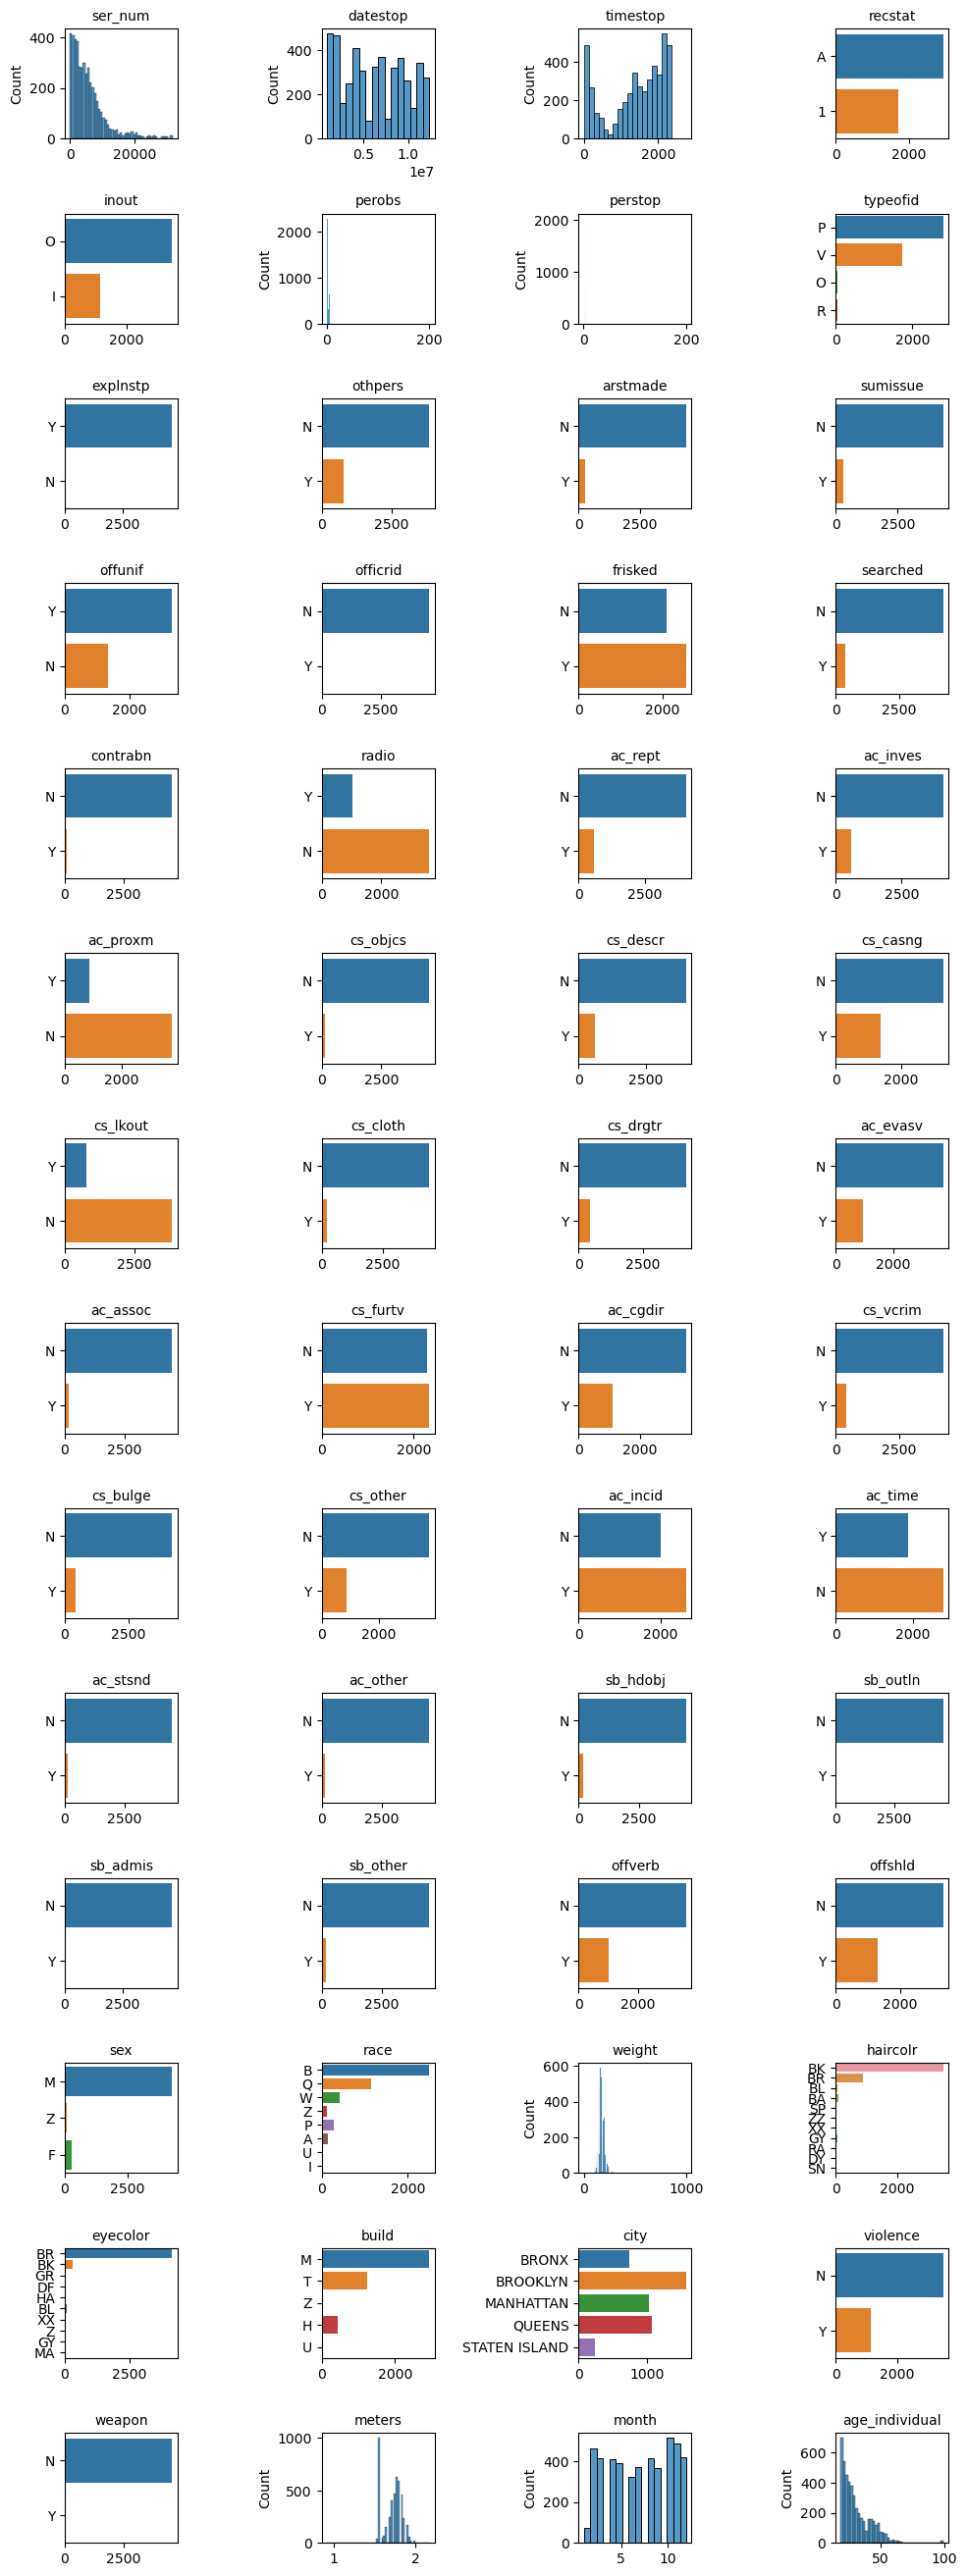

In [66]:
#grafico de atributos
cols = 4
rows = int(df.shape[1] / cols)+1
size_fact = 7
plt.figure(figsize=(10, cols*size_fact))

for i, col in enumerate(df):
    if df[col].dtype == 'object':
        plt.subplot(rows, cols, i + 1)
        sns.countplot(y = df[col])
        plt.title(col, fontsize=10)
        plt.xlabel('')
        plt.ylabel('')
    else:
        plt.subplot(rows, cols, i + 1)
        sns.histplot(df[col])
        plt.title(col, fontsize=10)
        plt.xlabel('')
plt.tight_layout()

In [67]:
print(df.shape)
print(df_test.shape)

(4636, 56)
(4749, 56)


La probabilidad de que un individuo sea arrestado en uno de los cinco
barrios, condicional al género y a la raza. Concluya, ¿qué implicancias éticas tienen
algunas conclusiones de lo que observa?.

* las Mujeres de raza P tiene un 20% de probabilidades de ser arrestadas
* En manhatan las probabilidades de arresto son mayores para algunas razas que pa otras cities

In [68]:
df_c = df[['city', 'sex', 'race', 'arstmade']]
casos_totales = df_c.groupby(['city', 'sex', 'race']).size()
casos_arrestados = df_c[df_c['arstmade'] == 'Y'].groupby(['city', 'sex', 'race']).size()

prob_cond = casos_arrestados/casos_totales*100
prob_cond = prob_cond.dropna()
print(prob_cond)
#print(prob_cond)

city           sex  race
BRONX          F    B         4.347826
               M    B         5.263158
                    P         7.692308
                    Q         6.030151
BROOKLYN       F    B        11.111111
                    Q        10.526316
               M    A         4.347826
                    B         3.861386
                    Q         4.803493
                    W         5.217391
                    Z         7.692308
               Z    Z         7.142857
MANHATTAN      F    B        17.647059
                    P        20.000000
                    Q        14.285714
                    W         7.692308
               M    A         5.263158
                    B         9.270217
                    P         8.235294
                    Q         7.874016
                    U        12.500000
                    W        12.000000
                    Z        13.333333
               Z    U       100.000000
                    Z        12.500000


In [69]:
#identificación de columnas categóricas
categoricas = preproc_nyc_sqf.infer_datatype(df, 'object')
categoricas2010 = preproc_nyc_sqf.infer_datatype(df_test, 'object')

#traspaso de las columnas categoricas a dummies 2009
df = pd.get_dummies(columns=categoricas, data=df, drop_first=True)

#traspaso de las columnas categoricas a dummies 2010
df_test = pd.get_dummies(columns=categoricas2010, data=df_test, drop_first=True)

print(df.shape)
print(df_test.shape)

(4636, 88)
(4749, 88)


In [70]:
#transformación de columnas continuas con standar scaler
numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numericos2010 = df_test.select_dtypes(include=['int64', 'float64']).columns.tolist()

scaler = StandardScaler()
df[numericas] = scaler.fit_transform(df[numericas])
df_test[numericos2010] = scaler.fit_transform(df_test[numericos2010])
df.head()

,ser_num,datestop,timestop,perobs,perstop,weight,meters,month,age_individual,recstat_A,...,build_M,build_T,build_U,build_Z,city_BROOKLYN,city_MANHATTAN,city_QUEENS,city_STATEN ISLAND,violence_Y,weapon_Y
0,-0.731731,-0.654226,-1.682487,-0.343719,-0.563565,-0.721157,0.682410,-0.901967,-0.632155,1,...,1,0,0,0,0,0,0,0,0,0
2,0.469343,1.097022,0.070695,-0.343719,-0.726441,1.182951,1.757046,0.905085,-0.900474,0,...,1,0,0,0,0,0,0,0,0,0
3,-0.886786,-1.467409,0.592666,0.447262,-0.074938,-1.355859,-0.392227,1.507435,-0.811034,1,...,0,1,0,0,1,0,0,0,0,0
5,-0.106572,-0.308623,0.852987,0.842752,-0.726441,0.040486,0.413750,-0.600791,1.424958,0,...,1,0,0,0,0,1,0,0,0,0
6,1.095052,1.439721,-1.710378,0.447262,-0.074938,-0.086454,-1.439998,1.206260,-0.989913,0,...,0,1,0,0,1,0,0,0,0,0


### 5. Modelación

#### 5.1 Modelos de clasificación de arresto o no

In [71]:
#creación de copias para manejrar los dos problemas de clasificación
df_arresto = df.copy()
df_arresto_test = df_test.copy()

#Sacamos los vectores objetivos de las matrices de entrenamiento y prueba
y_train = df_arresto.pop('arstmade_Y')
y_test = df_arresto_test.pop('arstmade_Y')

#liminamos los vectores objetivos del otro problema
X_train = df_arresto.drop(columns='violence_Y')
X_test = df_arresto_test.drop(columns='violence_Y')


#aplicación de SMOTE para equiparar la calse desbalanceada
smote = SMOTE(random_state=11238)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
#X_test_resampled, y_test_resampled = smote.fit_resample(df_arresto_test, y_test)
print(X_train_resampled.shape)
print(y_train_resampled.shape)

(8710, 86)
(8710,)


In [72]:
#funciones para reportar metricas
#funcion para reportar mejores parametros y puntuación:
def best_hyperparams(model):
    print("Mejores parámetros encontrados: ", model.best_params_)
    print("Mejor puntuación: ", model.best_score_)

#### Modelo 1: Analisis lineal discriminante

In [73]:
#creación del modelo
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_resampled, y_train_resampled)

#predicciones
yhat_pred_oversamp = lda_model.predict(X_test)

#evaluación del modelo
print(classification_report(y_test, yhat_pred_oversamp))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4440
           1       0.65      0.29      0.40       309

    accuracy                           0.94      4749
   macro avg       0.80      0.64      0.69      4749
weighted avg       0.93      0.94      0.93      4749



In [74]:
#with open('FMLL-LDA.pkl', 'wb') as file:
#    pickle.dump(lda_model, file)

#### Modelo 2: SVC

In [75]:
#definición de parámetros de la grilla
params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'gamma': [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10,1000]}

#búsqueda de grilla
svc = GridSearchCV(SVC(kernel='rbf'), params, cv=2, return_train_score=True)
svc.fit(X_train_resampled, y_train_resampled)
best_hyperparams(svc)

Mejores parámetros encontrados:  {'C': 100, 'gamma': 0.1}
Mejor puntuación:  0.9727898966704938


In [76]:
#predicción
y_pred = svc.predict(X_test)

#evaluación del modelo
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      4440
           1       0.79      0.40      0.53       309

    accuracy                           0.95      4749
   macro avg       0.87      0.70      0.76      4749
weighted avg       0.95      0.95      0.95      4749



In [77]:
#with open('FMLL-SVC.pkl', 'wb') as file:
#    pickle.dump(svc, file)

#### Modelo 3: Adaboost y Gboost

In [78]:
#parametros para la grilla
params = {'learning_rate': [0.01, 0.1, 0.5],
          'n_estimators': [50, 100, 500, 1000,2000]}
params2 = {'learning_rate': [0.01, 0.1, 0.5],
          'n_estimators': [50, 100, 500, 1000,2000],
          'subsample': [0.1, 0.5, 0.9]}

improve_adaboost = GridSearchCV(AdaBoostClassifier(random_state=11238), params, cv=2).fit(X_train_resampled, y_train_resampled)

In [79]:
improve_gboost = GridSearchCV(GradientBoostingClassifier(random_state=11238), params, cv=2).fit(X_train_resampled, y_train_resampled)

In [80]:
best_hyperparams(improve_adaboost)
best_hyperparams(improve_gboost)

Mejores parámetros encontrados:  {'learning_rate': 0.5, 'n_estimators': 2000}
Mejor puntuación:  0.9601607347876004
Mejores parámetros encontrados:  {'learning_rate': 0.1, 'n_estimators': 2000}
Mejor puntuación:  0.969804822043628


In [81]:
#predicciones
best_ada = improve_adaboost.best_estimator_
y_pred = best_ada.predict(X_test)

#evalauación del modelo
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.97      0.52      0.68      4440
           1       0.10      0.78      0.18       309

    accuracy                           0.54      4749
   macro avg       0.54      0.65      0.43      4749
weighted avg       0.92      0.54      0.64      4749



In [82]:
#predicciones
best_gboo = improve_adaboost.best_estimator_
y_pred = best_gboo.predict(X_test)

#evalauación del modelo
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.97      0.52      0.68      4440
           1       0.10      0.78      0.18       309

    accuracy                           0.54      4749
   macro avg       0.54      0.65      0.43      4749
weighted avg       0.92      0.54      0.64      4749



In [83]:
#with open('FMLL-ADAboost.pkl', 'wb') as file:
#    pickle.dump(improve_adaboost, file)
#with open('FMLL-GBoost.pkl', 'wb') as file:
#    pickle.dump(improve_gboost, file)

El modelo con mejor desempeño fue el SVC con un accuracy del 95% y con un f1 bastante alto para lograr identificar la clase 0, pero muy malo para identificar la clase 1

A continuación se presenta una función para graficar los atributos más importantes para el modelo para el modelo improve_gboost. Los atributos más importantes son los siguientes:
* searched_Y
* perobs
* persotp
* cs_casng_Y
* input_O

In [84]:
def plot_importance(fit_model, feat_names):
    """TODO: Docstring for plot_importance.

    :fit_model: TODO
    :: TODO
    :returns: TODO

    """
    tmp_importance = fit_model.feature_importances_
    sort_importance = np.argsort(tmp_importance)[::-1]
    names = [feat_names[i] for i in sort_importance]
    plt.title("Feature importance")
    print(len(feat_names))
    plt.barh(range(len(names)), tmp_importance[sort_importance])
    plt.yticks(range(len(names)), names, rotation=0)

86


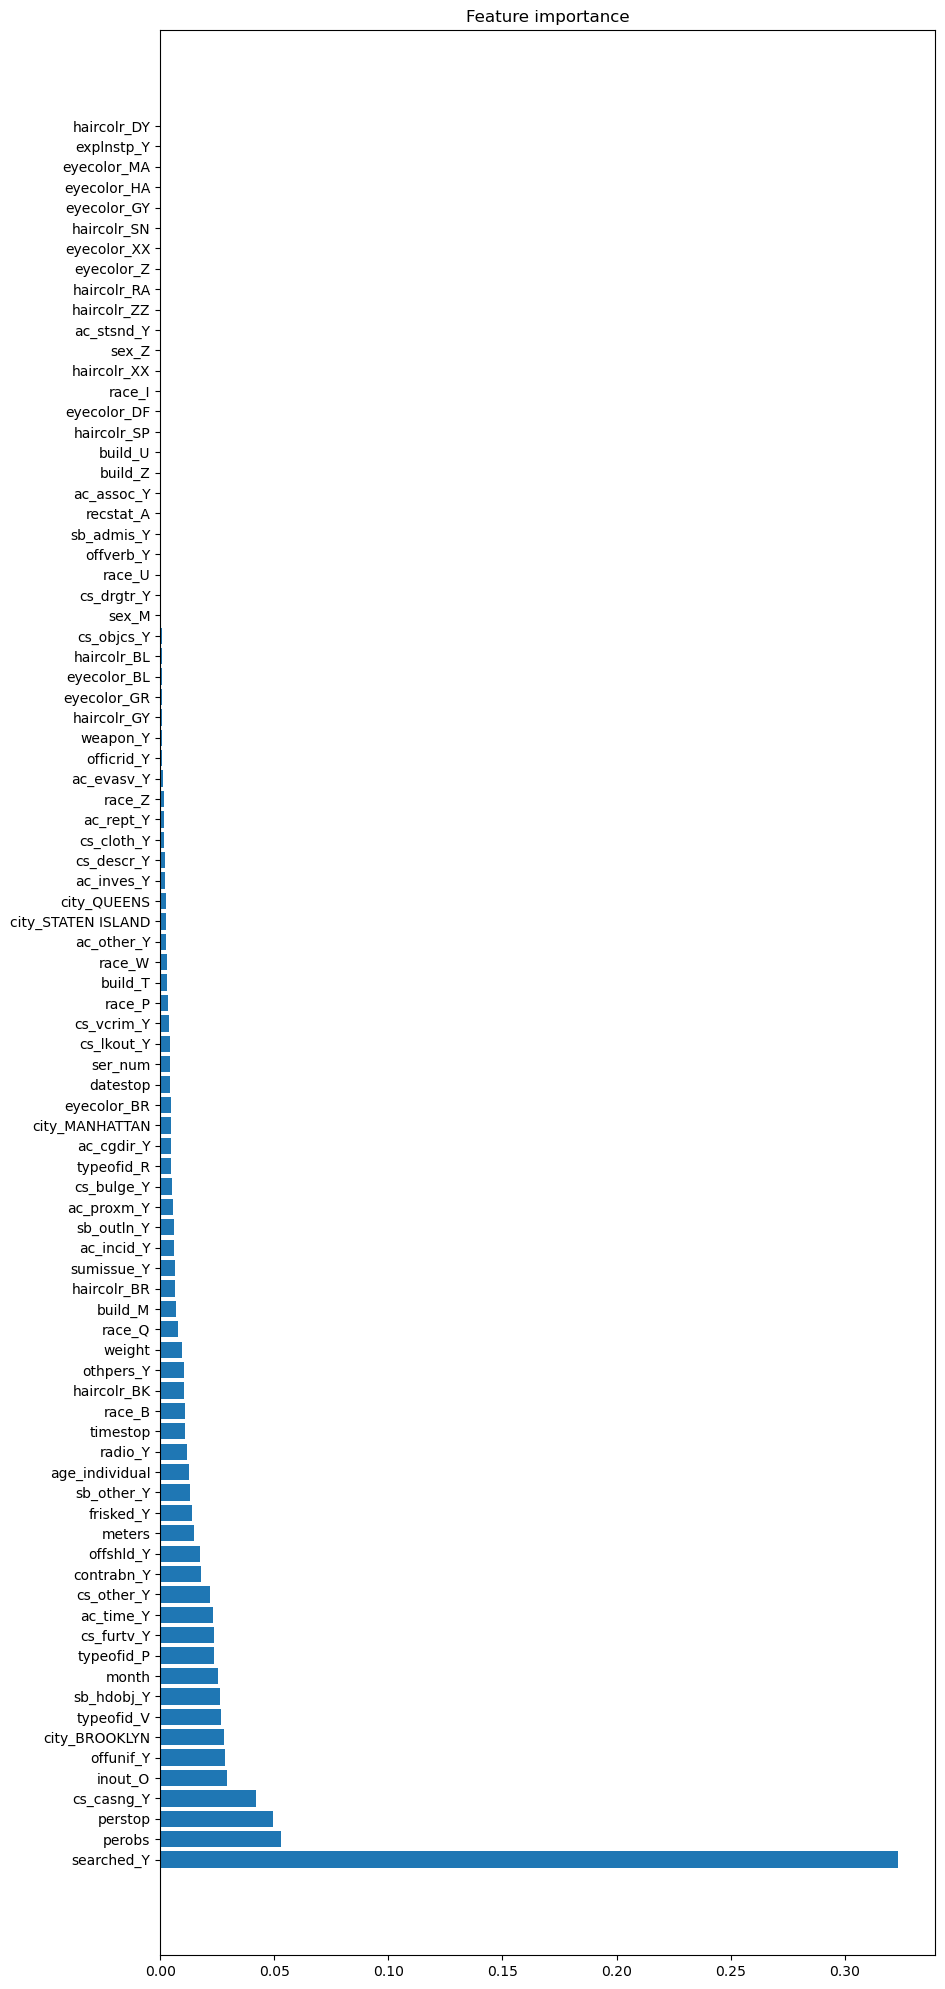

In [85]:
plt.figure(figsize=(10, 25))
plot_importance(improve_gboost.best_estimator_, X_train_resampled.columns)

#### 5.1 Modelos de clasificación de accion violenta o no

Para esto se recodificaron varios atributos que indicaban accion violenta en uno solo llamado violence, el cual será nuestro vector objetivo

In [86]:
#creación de copias para manejrar los dos problemas de clasificación
df_violence = df.copy()
df_violence_test = df_test.copy()

#Sacamos los vectores objetivos de las matrices de entrenamiento y prueba
y_train_2 = df_violence.pop('violence_Y')
y_test_2 = df_violence_test.pop('violence_Y')

#liminamos los vectores objetivos del otro problema
X_train_2 = df_violence.drop(columns='arstmade_Y')
X_test_2 = df_violence_test.drop(columns='arstmade_Y')

#aplicación de SMOTE para equiparar la calse desbalanceada
smote = SMOTE(random_state=11238)
X_train_resampled_2, y_train_resampled_2 = smote.fit_resample(X_train_2, y_train_2)
#X_test_resampled, y_test_resampled = smote.fit_resample(df_violence_test, y_test)
print(X_train_resampled.shape)
print(y_train_resampled.shape)

(8710, 86)
(8710,)


#### 1. Análisis Lineal discriminante

In [87]:
#creación del modelo
lda_model_2 = LinearDiscriminantAnalysis()
lda_model_2.fit(X_train_resampled_2, y_train_resampled_2)

#predicciones
yhat_pred_oversamp = lda_model_2.predict(X_test_2)

#evaluación del modelo
print(classification_report(y_test_2, yhat_pred_oversamp))

              precision    recall  f1-score   support

           0       0.87      0.69      0.77      3641
           1       0.39      0.65      0.49      1108

    accuracy                           0.68      4749
   macro avg       0.63      0.67      0.63      4749
weighted avg       0.75      0.68      0.70      4749



In [88]:
#with open('FMLL-LDA-2.pkl', 'wb') as file:
#    pickle.dump(lda_model_2, file)

#### 2. Modelo 2: SVC

In [89]:
#definición de parámetros de la grilla
params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'gamma': [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10,1000]}

#búsqueda de grilla
svc2 = GridSearchCV(SVC(kernel='rbf'), params, cv=2, return_train_score=True)
svc2.fit(X_train_resampled_2, y_train_resampled_2)
best_hyperparams(svc2)

#predicción
y_pred = svc2.predict(X_test_2)

#evaluación del modelo
print("Informe de clasificación:")
print(classification_report(y_test_2, y_pred))

Mejores parámetros encontrados:  {'C': 10, 'gamma': 0.1}
Mejor puntuación:  0.796
Informe de clasificación:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      3641
           1       0.40      0.46      0.43      1108

    accuracy                           0.71      4749
   macro avg       0.61      0.63      0.62      4749
weighted avg       0.73      0.71      0.72      4749



#### Modelo 3: Árboles de Decisión

In [90]:
#parametros del modelo
params = {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}

# Crear el clasificador de árbol de decisión
clf = DecisionTreeClassifier()

#grid search
grid_search_tree = GridSearchCV(clf, params, cv=5)
grid_search_tree.fit(X_train_resampled_2, y_train_resampled_2)

#mejores parametros
best_hyperparams(grid_search_tree)

#predicciones con los mejores parametros
best_clf = grid_search_tree.best_estimator_
y_pred = best_clf.predict(X_test_2)

#evaluación
print("Informe de clasificación:")
print(classification_report(y_test_2, y_pred))

#guardado del modelo
#with open('FMLL-DT-2.pkl', 'wb') as file:
#    pickle.dump(grid_search_tree, file)

Mejores parámetros encontrados:  {'max_depth': None, 'min_samples_split': 2}
Mejor puntuación:  0.7717142857142857
Informe de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.26      0.41      3641
           1       0.27      0.88      0.41      1108

    accuracy                           0.41      4749
   macro avg       0.57      0.57      0.41      4749
weighted avg       0.73      0.41      0.41      4749



#### Modelo 4: Random Forest

In [91]:
#parámetros para la grilla
params = {'n_estimators': [100, 200, 300],  # Número de árboles en el bosque
    'max_depth': [None, 5, 10],  # Profundidad máxima de cada árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4]}  # Número mínimo de muestras requeridas en cada hoja del árbol

#creción del modelo
rf = RandomForestClassifier()
grid_search_rf = GridSearchCV(rf, params, cv=2)
grid_search_rf.fit(X_train_resampled_2, y_train_resampled_2)

#mejores parametros
best_hyperparams(grid_search_rf)

#predicciones
best_rf = grid_search_rf.best_estimator_
y_pred = best_rf.predict(X_test_2)

#evalauación del modelo
print("Informe de clasificación:")
print(classification_report(y_test_2, y_pred))

#guardado del modelo
#with open('FMLL-RF-2.pkl', 'wb') as file:
#    pickle.dump(grid_search_rf, file)

Mejores parámetros encontrados:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mejor puntuación:  0.7769999999999999
Informe de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.71      0.78      3641
           1       0.40      0.64      0.49      1108

    accuracy                           0.69      4749
   macro avg       0.63      0.67      0.64      4749
weighted avg       0.76      0.69      0.71      4749



#### Modelo 5: Adabost y Gboost

In [92]:
#parametros para la grilla
params = {'learning_rate': [0.01, 0.1, 0.5],
          'n_estimators': [50, 100, 500, 1000,2000]}
params2 = {'learning_rate': [0.01, 0.1, 0.5],
          'n_estimators': [50, 100, 500, 1000,2000],
          'subsample': [0.1, 0.5, 0.9]}

#modelo con el gridsearch
improve_adaboost = GridSearchCV(AdaBoostClassifier(random_state=11238), params, cv=2).fit(X_train_resampled_2, y_train_resampled_2)
improve_gboost = GridSearchCV(GradientBoostingClassifier(random_state=11238), params, cv=2).fit(X_train_resampled_2, y_train_resampled_2)

#mejores parametros
best_hyperparams(improve_adaboost)
best_hyperparams(improve_gboost)

#predicciones adaboost
best_ada = improve_adaboost.best_estimator_
y_pred = best_ada.predict(X_test_2)

#evalauación del modelo adaboost
print("Informe de clasificación:")
print(classification_report(y_test_2, y_pred))

#predicciones Gboost
best_gboo = improve_gboost.best_estimator_
y_pred = best_gboo.predict(X_test_2)

#evalauación del modelo Gboost
print("Informe de clasificación:")
print(classification_report(y_test_2, y_pred))

#gusrdado de los modelos
#with open('FMLL-AdaB-2.pkl', 'wb') as file:
#    pickle.dump(improve_adaboost, file)

#with open('FMLL-GBoo-2.pkl', 'wb') as file:
#    pickle.dump(improve_gboost, file)

Mejores parámetros encontrados:  {'learning_rate': 0.5, 'n_estimators': 2000}
Mejor puntuación:  0.7484285714285714
Mejores parámetros encontrados:  {'learning_rate': 0.1, 'n_estimators': 2000}
Mejor puntuación:  0.7629999999999999
Informe de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.09      0.16      3641
           1       0.24      0.97      0.39      1108

    accuracy                           0.30      4749
   macro avg       0.58      0.53      0.28      4749
weighted avg       0.75      0.30      0.22      4749

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.95      0.13      0.23      3641
           1       0.26      0.98      0.40      1108

    accuracy                           0.33      4749
   macro avg       0.60      0.55      0.32      4749
weighted avg       0.79      0.33      0.27      4749



El modelo con mejor accuracy corresponde al de analisis lineal discriminante con un valor de 77%

#### Modelo 6: LigthGBM

### Hito 3

Para los modelos de clasifición de si la persona es arrestada o no

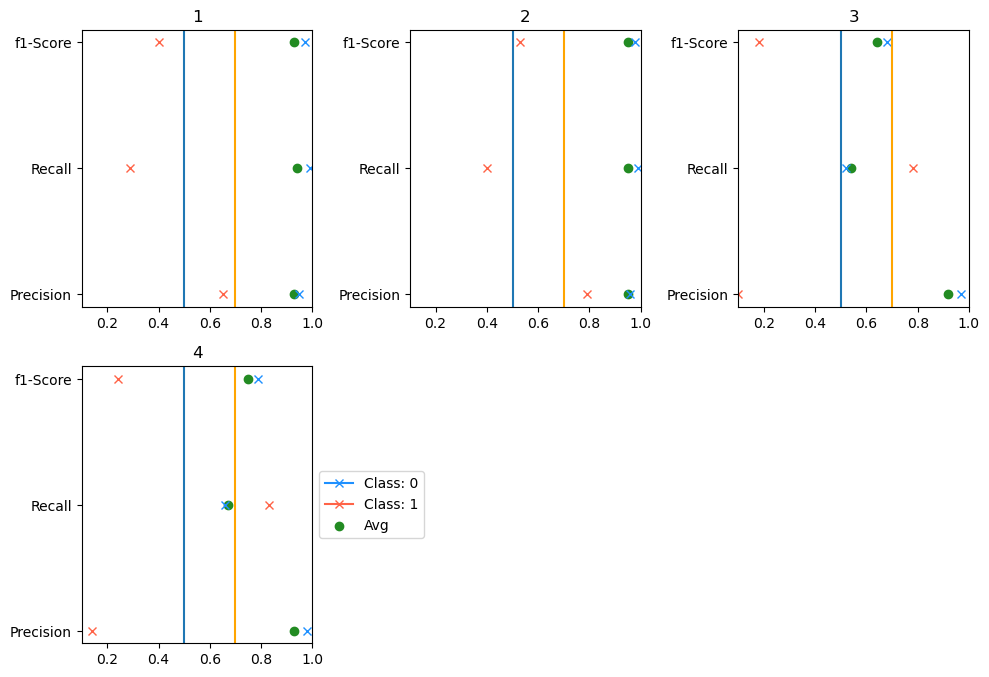

In [93]:
#cálculo de los modelos con los best estimators
m1 = LinearDiscriminantAnalysis().fit(X_train_resampled, y_train_resampled)
m2 = SVC(kernel='rbf', C = 100, gamma = 0.1).fit(X_train_resampled, y_train_resampled)
m3 = AdaBoostClassifier(learning_rate = 0.5, n_estimators = 2000).fit(X_train_resampled, y_train_resampled)
m4 = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 2000).fit(X_train_resampled, y_train_resampled)

#predicciones
y1 = m1.predict(X_test)
y2 = m2.predict(X_test)
y3 = m3.predict(X_test)
y4 = m4.predict(X_test)

pred = [y1, y2, y3, y4]

#graficos
plt.figure(figsize=(10,10))
for i, pred in enumerate(pred):
    plt.subplot(3, 3, i+1)
    plot_classification_report(y_test, pred)
    plt.axvline(.5)
    plt.axvline(.7, color='orange')
    plt.xlim((0.1, 1))
    plt.title(i+1)
    plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Para el primer caso el modelo con mejor desempeño es el de SVC, con un accuracy del 95% versus los otros 3 que presentan un desempeño muy bajo. Seleccionaremos este modelo para enviar

Modelo de clasificación de acción violenta o no

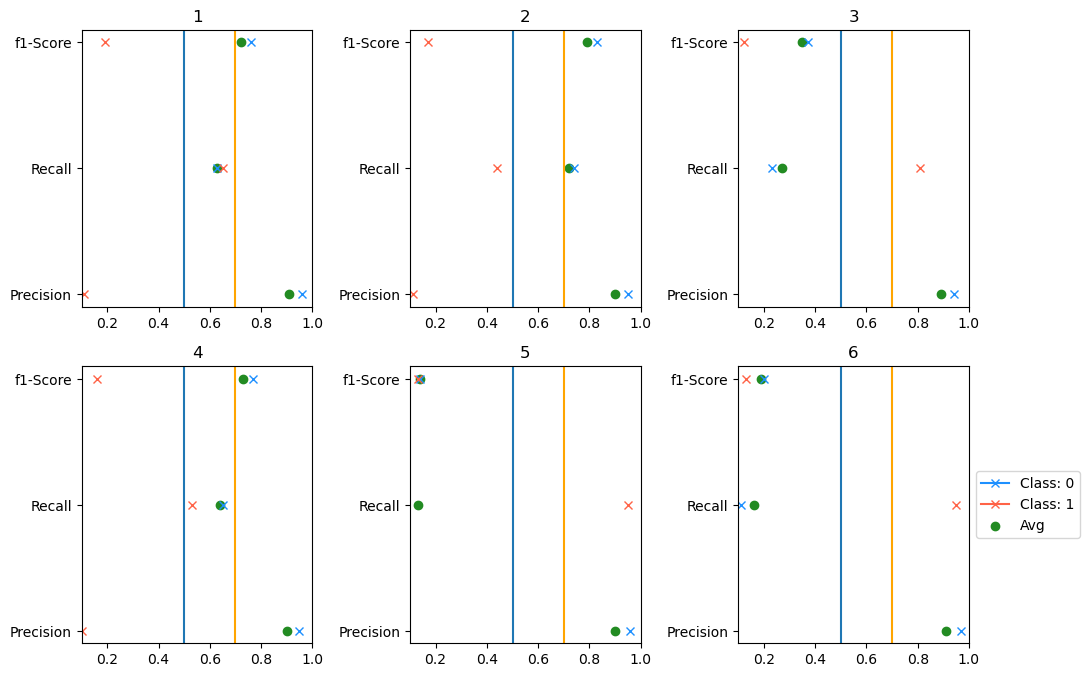

In [95]:
#cálculo de los modelos con los best estimators
m5 = LinearDiscriminantAnalysis().fit(X_train_resampled_2, y_train_resampled_2)
m6 = SVC(C = 10, gamma = 0.1).fit(X_train_resampled_2, y_train_resampled_2)
m7 = DecisionTreeClassifier(max_depth = None, min_samples_split = 2).fit(X_train_resampled_2, y_train_resampled_2)
m8 = RandomForestClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 300).fit(X_train_resampled_2, y_train_resampled_2)
m9 = AdaBoostClassifier(learning_rate = 0.5, n_estimators = 2000).fit(X_train_resampled_2, y_train_resampled_2)
m10 = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 2000).fit(X_train_resampled_2, y_train_resampled_2)

#predicciones
y5 = m5.predict(X_test_2)
y6 = m6.predict(X_test_2)
y7 = m7.predict(X_test_2)
y8 = m8.predict(X_test_2)
y9 = m9.predict(X_test_2)
y10 = m10.predict(X_test_2)

pred = [y5, y6, y7, y8, y9, y10]

#graficos
plt.figure(figsize=(10,10))
for i, pred in enumerate(pred):
    plt.subplot(3, 3, i+1)
    plot_classification_report(y_test, pred)
    plt.axvline(.5)
    plt.axvline(.7, color='orange')
    plt.xlim((0.1, 1))
    plt.title(i+1)
    plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Los mejores modelos para este caso corresponden a los de LDA y SVC con un accuracy del 68% y 71% respectivamente.